In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [1]:
import tensorflow as tf
tf.random.set_seed(42)

import os
import glob
import imageio
import numpy as np
from tqdm import tqdm
from tensorflow import keras
from tensorflow.keras import layers
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")

/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:98: UserWarning: unable to load libtensorflow_io_plugins.so: unable to open file: libtensorflow_io_plugins.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so: undefined symbol: _ZN3tsl6StatusC1EN10tensorflow5error4CodeESt17basic_string_viewIcSt11char_traitsIcEENS_14SourceLocationE']
  warnings.warn(f"unable to load libtensorflow_io_plugins.so: {e}")
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:104: UserWarning: file system plugins are not loaded: unable to open file: libtensorflow_io.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so: undefined symbol: _ZTVN10tenso

In [2]:
BATCH_SIZE = 8
NUM_SAMPLES = 32
POS_ENCODE_DIMS = 16
EPOCHS = 20

--2023-05-31 13:13:06--  http://cseweb.ucsd.edu/~viscomp/projects/LF/papers/ECCV20/nerf/tiny_nerf_data.npz
Resolving cseweb.ucsd.edu (cseweb.ucsd.edu)... 132.239.8.30
Connecting to cseweb.ucsd.edu (cseweb.ucsd.edu)|132.239.8.30|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://cseweb.ucsd.edu//~viscomp/projects/LF/papers/ECCV20/nerf/tiny_nerf_data.npz [following]
--2023-05-31 13:13:07--  https://cseweb.ucsd.edu//~viscomp/projects/LF/papers/ECCV20/nerf/tiny_nerf_data.npz
Connecting to cseweb.ucsd.edu (cseweb.ucsd.edu)|132.239.8.30|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 12727482 (12M)
Saving to: ‘tiny_nerf_data.npz’

tiny_nerf_data.npz  100%[===================>]  12.14M  38.3MB/s    in 0.3s    

2023-05-31 13:13:07 (38.3 MB/s) - ‘tiny_nerf_data.npz’ saved [12727482/12727482]



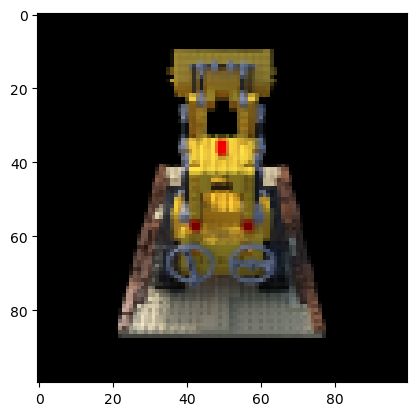

In [3]:
file_name = "tiny_nerf_data.npz"
url = "https://people.eecs.berkeley.edu/~bmild/nerf/tiny_nerf_data.npz"
if not os.path.exists('tiny_nerf_data.npz'):
    !wget http://cseweb.ucsd.edu/~viscomp/projects/LF/papers/ECCV20/nerf/tiny_nerf_data.npz

data = np.load('tiny_nerf_data.npz')
images = data["images"]
im_shape = images.shape
(num_images, H, W, _) = images.shape
(poses, focal) = (data["poses"], data["focal"])
plt.imshow(images[np.random.randint(low=0, high=num_images)])
plt.show()

In [4]:
def encode_position(x):
    "Fourier encoding"
    positions = [x]
    for i in range(POS_ENCODE_DIMS):
        for fn in [tf.sin, tf.cos]:
            positions.append(fn(2.0 ** i * x))
    return tf.concat(positions, axis=-1)
import numpy as np

def encode_position_gaussian(x, sigma):
    "gaussian encoding"
    encoding = np.exp(-(x ** 2) / (2 * sigma ** 2))
    return encoding
import numpy as np

def encode_position_rbf(x, centers, sigma):
    "rbf encoding"
    encoding = np.exp(-(x - centers) ** 2 / (2 * sigma ** 2))
    return encoding

def get_rays(h, w, focal, pose):
    x, y = tf.meshgrid(
        tf.range(w, dtype=tf.float32),
        tf.range(h, dtype=tf.float32),
        indexing="xy",
    )
    
    norm_x = (x - width * 0.5) / focal
    norm_y = (y - height * 0.5) / focal
    directions = tf.stack([norm_x, -norm_y, -tf.ones_like(x)], axis=-1)
    camera_matrix = pose[:3, :3]
    height_width_focal = pose[:3, -1]
    transformed_dirs = directions[..., None, :]
    camera_dirs = transformed_dirs * camera_matrix
    ray_directions = tf.reduce_sum(camera_dirs, axis=-1)
    ray_origins = tf.broadcast_to(height_width_focal, tf.shape(ray_directions))
    return (ray_origins, ray_directions)
print(encode_position)

In [7]:
def render_rays(ray_origins, ray_directions, near, far, num_samples, rand=False):
    t_vals = tf.linspace(near, far, num_samples)
    if rand:
        shape = list(ray_origins.shape[:-1]) + [num_samples]
        noise = tf.random.uniform(shape=shape) * (far - near) / num_samples
        t_vals = t_vals + noise
    rays = ray_origins[..., None, :] + (
        ray_directions[..., None, :] * t_vals[..., None]
    )
    rays_flat = tf.reshape(rays, [-1, 3])
    rays_flat = encode_position(rays_flat)
    return (rays_flat, t_vals)

In [8]:
def map_fn(pose):
#     near and far needs to be calculated from colmap, we tested different values, and found out that
# those parameters have a drastic impact on the rendered image, along with number of samples
    (ray_origins, ray_directions) = get_rays(height=H, width=W, focal=focal, pose=pose)
    (rays_flat, t_vals) = render_flat_rays(
        ray_origins=ray_origins,
        ray_directions=ray_directions,
        near=2.0,
        far=6.0,
        num_samples=NUM_SAMPLES,
        rand=True,
    )
    return (rays_flat, t_vals)

DATASET 

In [9]:
split_index = int(num_images * 0.8)

# Split the images into training and validation.
train_images = images[:split_index]
val_images = images[split_index:]

# Split the poses into training and validation.
train_poses = poses[:split_index]
val_poses = poses[split_index:]

# Make the training pipeline.
train_img_ds = tf.data.Dataset.from_tensor_slices(train_images)
train_pose_ds = tf.data.Dataset.from_tensor_slices(train_poses)
train_ray_ds = train_pose_ds.map(map_fn, num_parallel_calls=AUTO)
training_ds = tf.data.Dataset.zip((train_img_ds, train_ray_ds))
train_ds = (
    training_ds.shuffle(BATCH_SIZE)
    .batch(BATCH_SIZE, drop_remainder=True, num_parallel_calls=AUTO)
    .prefetch(AUTO)
)

# Make the validation pipeline.
val_img_ds = tf.data.Dataset.from_tensor_slices(val_images)
val_pose_ds = tf.data.Dataset.from_tensor_slices(val_poses)
val_ray_ds = val_pose_ds.map(map_fn, num_parallel_calls=AUTO)
validation_ds = tf.data.Dataset.zip((val_img_ds, val_ray_ds))
val_ds = (
    validation_ds.shuffle(BATCH_SIZE)
    .batch(BATCH_SIZE, drop_remainder=True, num_parallel_calls=AUTO)
    .prefetch(AUTO)
)

In [10]:
def get_nerf_model(num_layers, num_pos, transition = 4):
    inputs = keras.Input(shape=(num_pos, 2 * 3 * POS_ENCODE_DIMS + 3))
    x = inputs
    for i in range(num_layers):
        x = layers.Dense(units=64, activation="relu")(x)
        if i % transition == 0 and i > 0:
            # Inject residual connection.
            x = layers.concatenate([x, inputs], axis=-1)
    outputs = layers.Dense(units=4)(x)
    return keras.Model(inputs=inputs, outputs=outputs)

In [11]:
def render_rgb_depth(model, rays_flat, t_vals, rand=True, train=True):
    "Rendering equation calculation"
    if train:
        predictions = model(rays_flat)
    else:
        predictions = model.predict(rays_flat)
    predictions = tf.reshape(predictions, shape=(BATCH_SIZE, H, W, NUM_SAMPLES,4))
    rgb = tf.sigmoid(predictions[..., :-1])
    sigma_a = tf.nn.relu(predictions[..., -1])
    delta = t_vals[..., 1:] - t_vals[..., :-1]
    if rand:
        delta = tf.concat(
            [delta, tf.broadcast_to([1e10], shape=(BATCH_SIZE, H, W, 1))], axis=-1
        )
        alpha = 1.0 - tf.exp(-sigma_a * delta)
    else:
        delta = tf.concat(
            [delta, tf.broadcast_to([1e10], shape=(BATCH_SIZE, 1))], axis=-1
        )
        alpha = 1.0 - tf.exp(-sigma_a * delta[:, None, None, :])
    exp_term = 1.0 - alpha
    epsilon = 1e-10
    transmittance = tf.math.cumprod(exp_term + epsilon, axis=-1, exclusive=True)
    weights = alpha * transmittance
    rgb = tf.reduce_sum(weights[..., None] * rgb, axis=-2)

    if rand:
        depth_map = tf.reduce_sum(weights * t_vals, axis=-1)
    else:
        depth_map = tf.reduce_sum(weights * t_vals[:, None, None], axis=-1)
    return (rgb, depth_map)

In [12]:
class NeRF(keras.Model):
    def __init__(self, nerf_model):
        super().__init__()
        self.nerf_model = nerf_model

    def compile(self, optimizer, loss_fn):
        super().compile()
        self.optimizer = optimizer
        self.loss_fn = loss_fn
        self.loss_tracker = keras.metrics.Mean(name="loss")
        self.psnr_metric = keras.metrics.Mean(name="psnr")

    def train_step(self, inputs):
        (images, rays) = inputs
        (rays_flat, t_vals) = rays

        with tf.GradientTape() as tape:
            rgb, _ = render_rgb_depth(
                model=self.nerf_model, rays_flat=rays_flat, t_vals=t_vals, rand=True
            )
            loss = self.loss_fn(images, rgb)
        trainable_variables = self.nerf_model.trainable_variables
        gradients = tape.gradient(loss, trainable_variables)
        self.optimizer.apply_gradients(zip(gradients, trainable_variables))
        psnr = tf.image.psnr(images, rgb, max_val=1.0)
        self.loss_tracker.update_state(loss)
        self.psnr_metric.update_state(psnr)
        return {"loss": self.loss_tracker.result(), "psnr": self.psnr_metric.result()}

    def test_step(self, inputs):
        (images, rays) = inputs
        (rays_flat, t_vals) = rays
        rgb, _ = render_rgb_depth(
            model=self.nerf_model, rays_flat=rays_flat, t_vals=t_vals, rand=True
        )
        loss = self.loss_fn(images, rgb)
        psnr = tf.image.psnr(images, rgb, max_val=1.0)
        self.loss_tracker.update_state(loss)
        self.psnr_metric.update_state(psnr)
        return {"loss": self.loss_tracker.result(), "psnr": self.psnr_metric.result()}
    @property
    def metrics(self):
        return [self.loss_tracker, self.psnr_metric]

In [13]:
test_imgs, test_rays = next(iter(train_ds))
test_rays_flat, test_t_vals = test_rays

loss_list = []


class TrainMonitor(keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        loss = logs["loss"]
        loss_list.append(loss)
        test_recons_images, depth_maps = render_rgb_depth(
            model=self.model.nerf_model,
            rays_flat=test_rays_flat,
            t_vals=test_t_vals,
            rand=True,
            train=False,
        )

        # Plot the rgb, depth and the loss plot.
        fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(20, 5))
        ax[0].imshow(keras.preprocessing.image.array_to_img(test_recons_images[0]))
        ax[0].set_title(f"Predicted Image: {epoch:03d}")

        ax[1].imshow(keras.preprocessing.image.array_to_img(depth_maps[0, ..., None]))
        ax[1].set_title(f"Depth Map: {epoch:03d}")

        ax[2].plot(loss_list)
        ax[2].set_xticks(np.arange(0, EPOCHS + 1, 5.0))
        ax[2].set_title(f"Loss Plot: {epoch:03d}")

        fig.savefig(f"images/{epoch:03d}.png")
        plt.show()
        plt.close()

Epoch 1/20
1/1 [==============================] - 1s 1s/step- loss: 0.1395 - psnr: 8.64


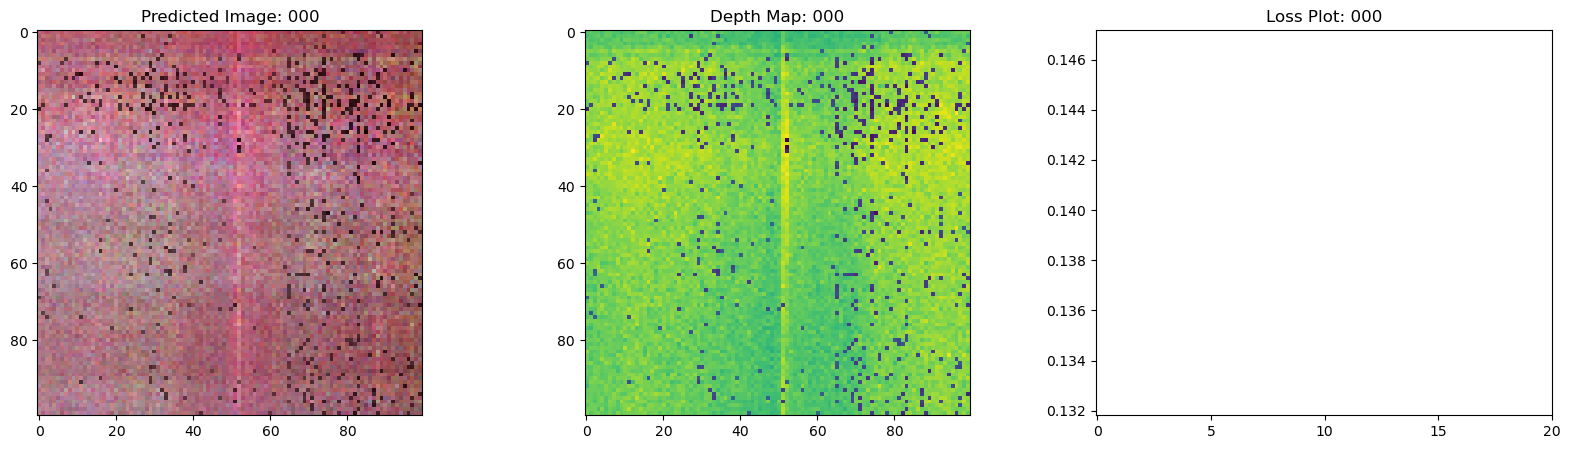

16/16 [==============================] - 48s 2s/step - loss: 0.1395 - psnr: 8.6404 - val_loss: 0.0859 - val_psnr: 10.7277
Epoch 2/20
1/1 [==============================] - 1s 804ms/steposs: 0.0670 - psnr: 12.24


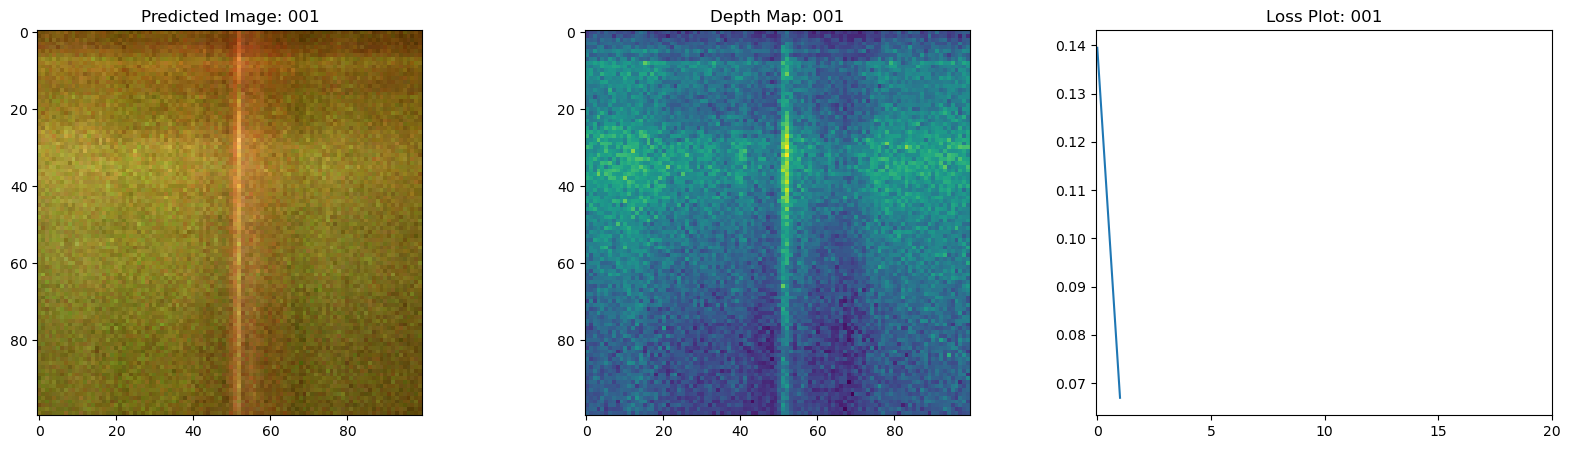

16/16 [==============================] - 38s 2s/step - loss: 0.0670 - psnr: 12.2462 - val_loss: 0.0693 - val_psnr: 12.0812
Epoch 3/20
1/1 [==============================] - 1s 938ms/steposs: 0.0612 - psnr: 12.49


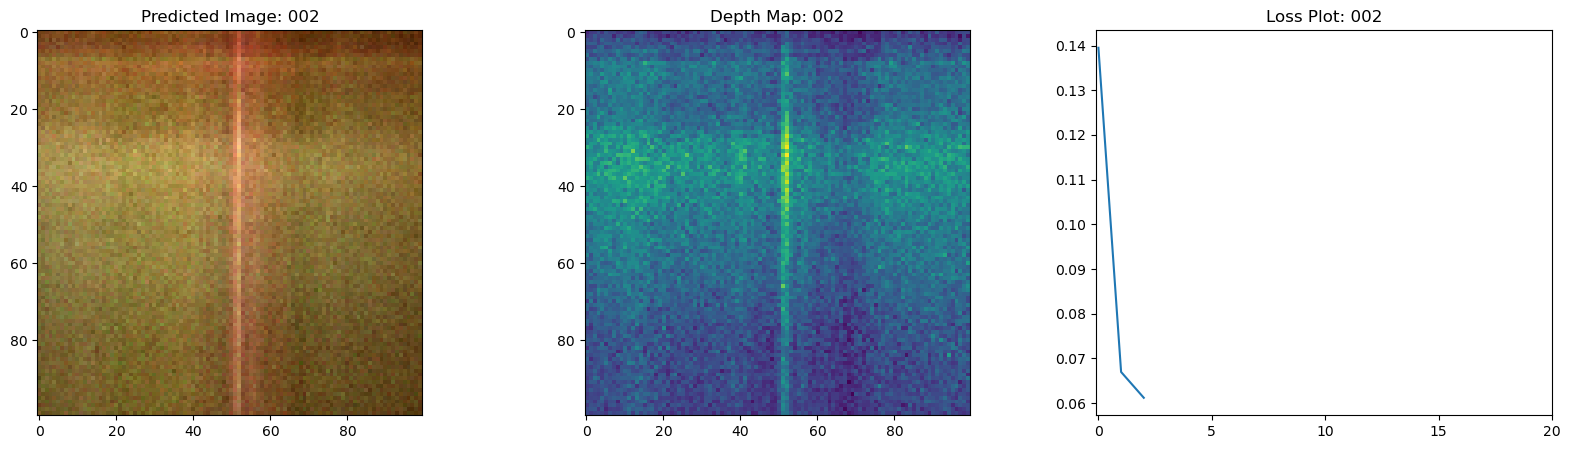

16/16 [==============================] - 41s 3s/step - loss: 0.0612 - psnr: 12.4900 - val_loss: 0.0681 - val_psnr: 11.9798
Epoch 4/20
1/1 [==============================] - 1s 834ms/steposs: 0.0596 - psnr: 12.70


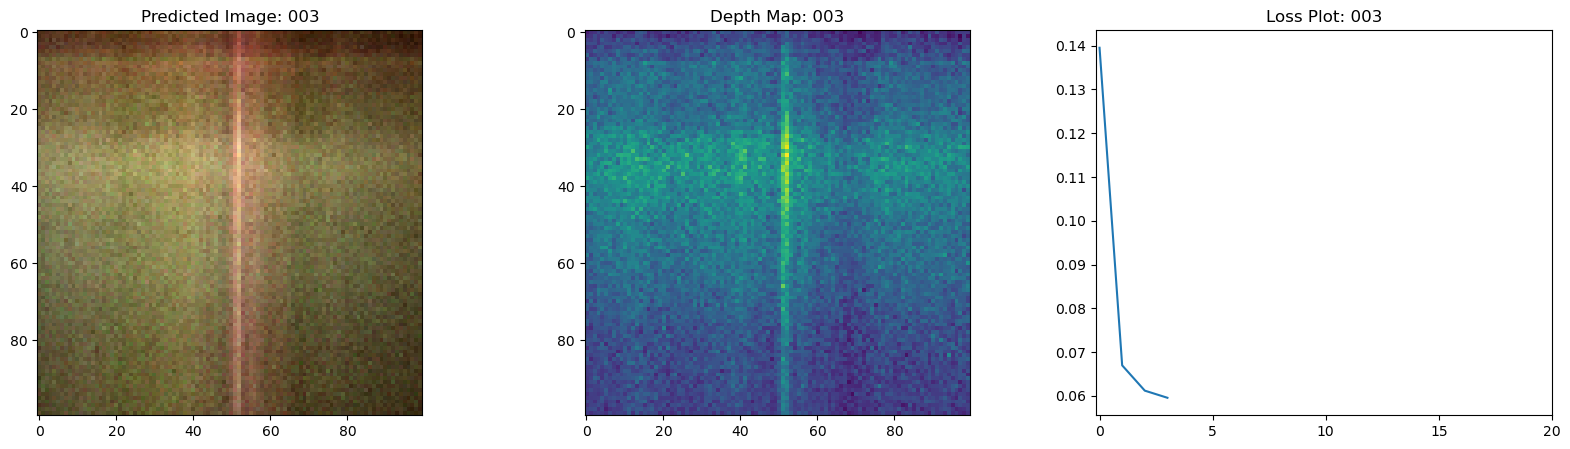

16/16 [==============================] - 49s 3s/step - loss: 0.0596 - psnr: 12.7047 - val_loss: 0.0655 - val_psnr: 12.2113
Epoch 5/20
1/1 [==============================] - 1s 868ms/steposs: 0.0585 - psnr: 12.74


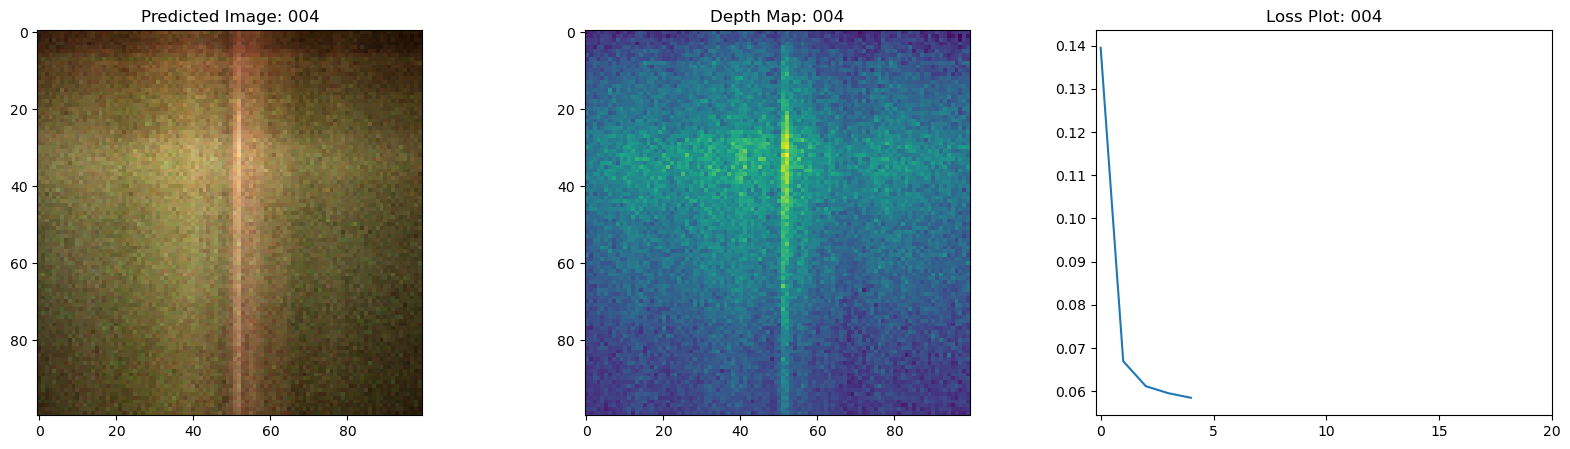

16/16 [==============================] - 39s 2s/step - loss: 0.0585 - psnr: 12.7405 - val_loss: 0.0624 - val_psnr: 12.4681
Epoch 6/20
1/1 [==============================] - 1s 826ms/steposs: 0.0558 - psnr: 12.95


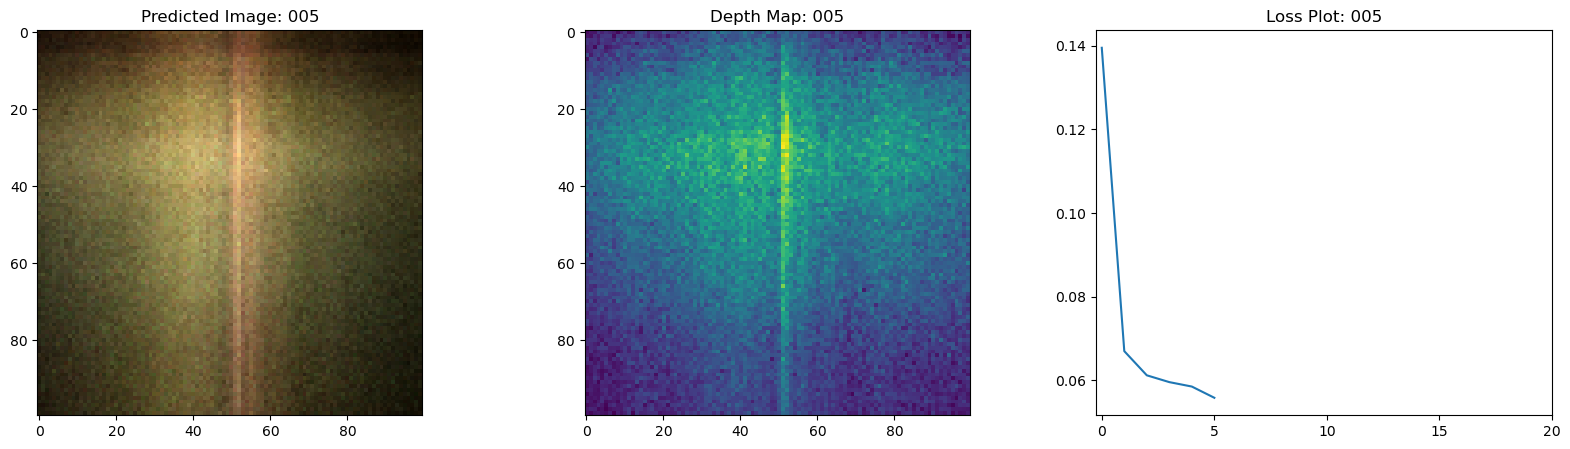

16/16 [==============================] - 41s 3s/step - loss: 0.0558 - psnr: 12.9592 - val_loss: 0.0589 - val_psnr: 12.6953
Epoch 7/20
1/1 [==============================] - 1s 831ms/steposs: 0.0538 - psnr: 13.12


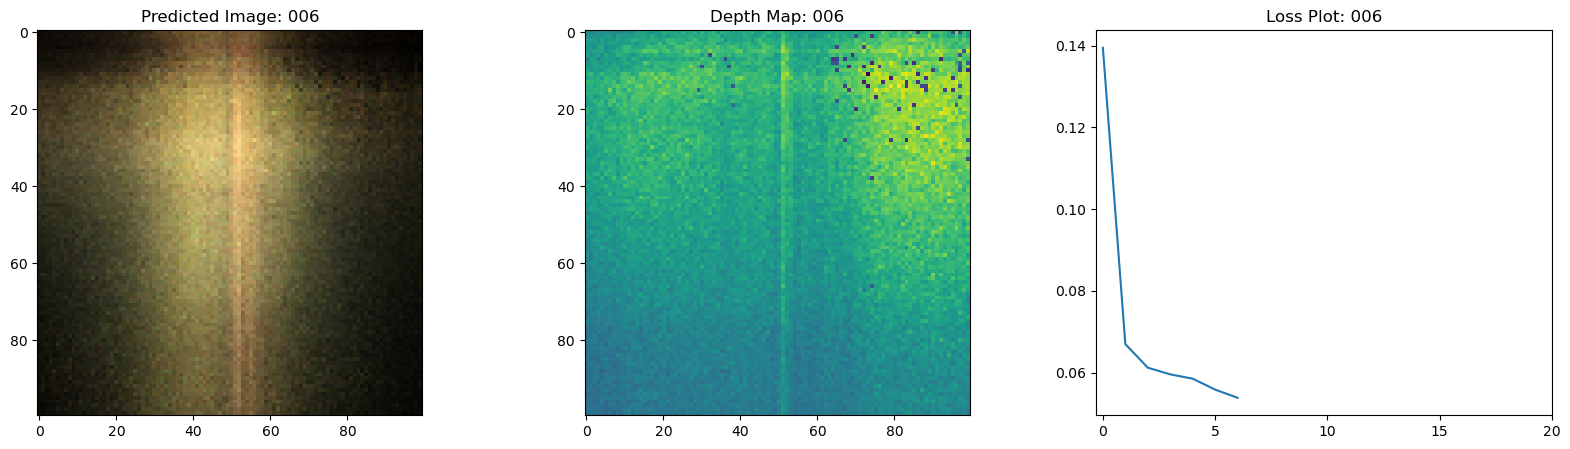

16/16 [==============================] - 41s 2s/step - loss: 0.0538 - psnr: 13.1210 - val_loss: 0.0546 - val_psnr: 12.8792
Epoch 8/20
1/1 [==============================] - 1s 810ms/steposs: 0.0458 - psnr: 13.78


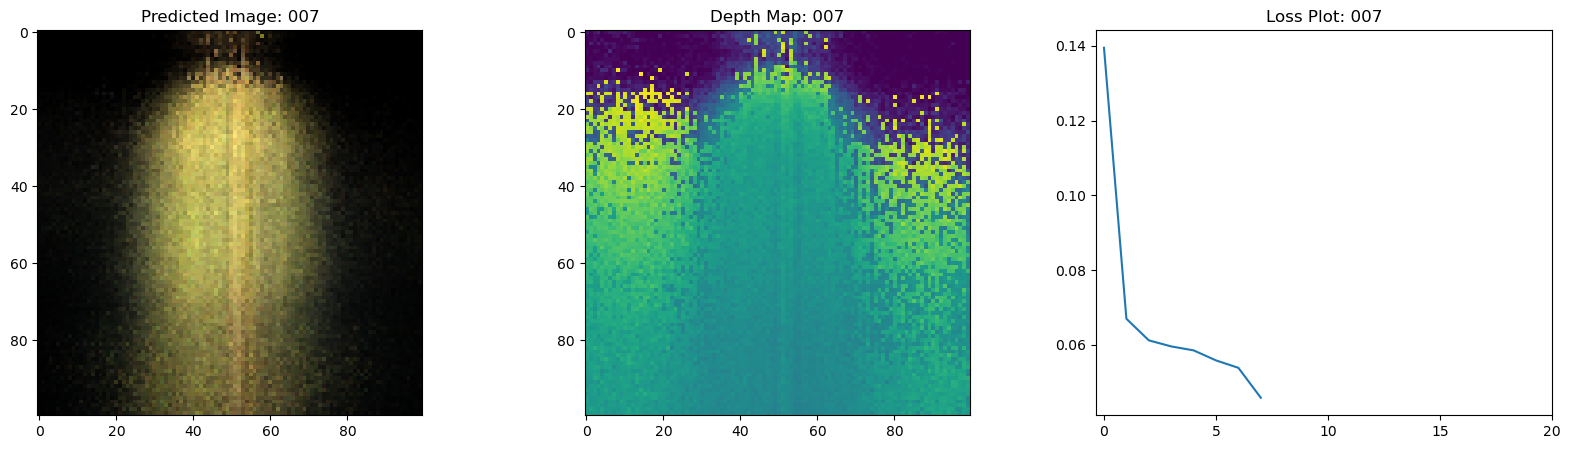

16/16 [==============================] - 38s 2s/step - loss: 0.0458 - psnr: 13.7896 - val_loss: 0.0415 - val_psnr: 14.1623
Epoch 9/20
1/1 [==============================] - 1s 841ms/steposs: 0.0345 - psnr: 15.00


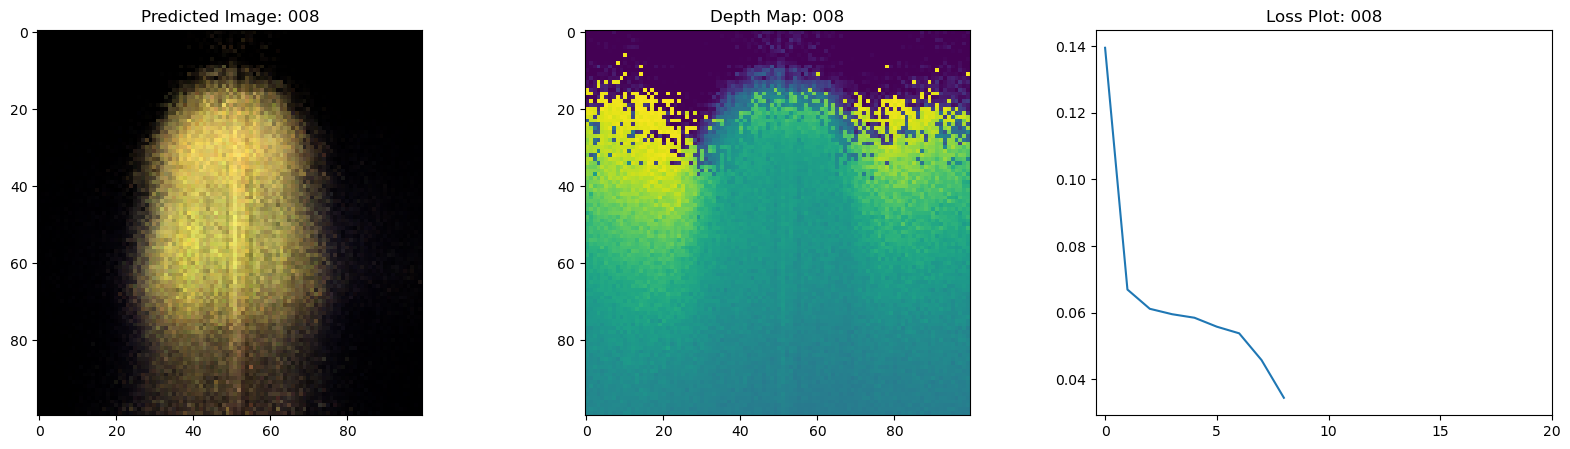

16/16 [==============================] - 41s 3s/step - loss: 0.0345 - psnr: 15.0008 - val_loss: 0.0314 - val_psnr: 15.3033
Epoch 10/20
1/1 [==============================] - 1s 921ms/steposs: 0.0290 - psnr: 15.65


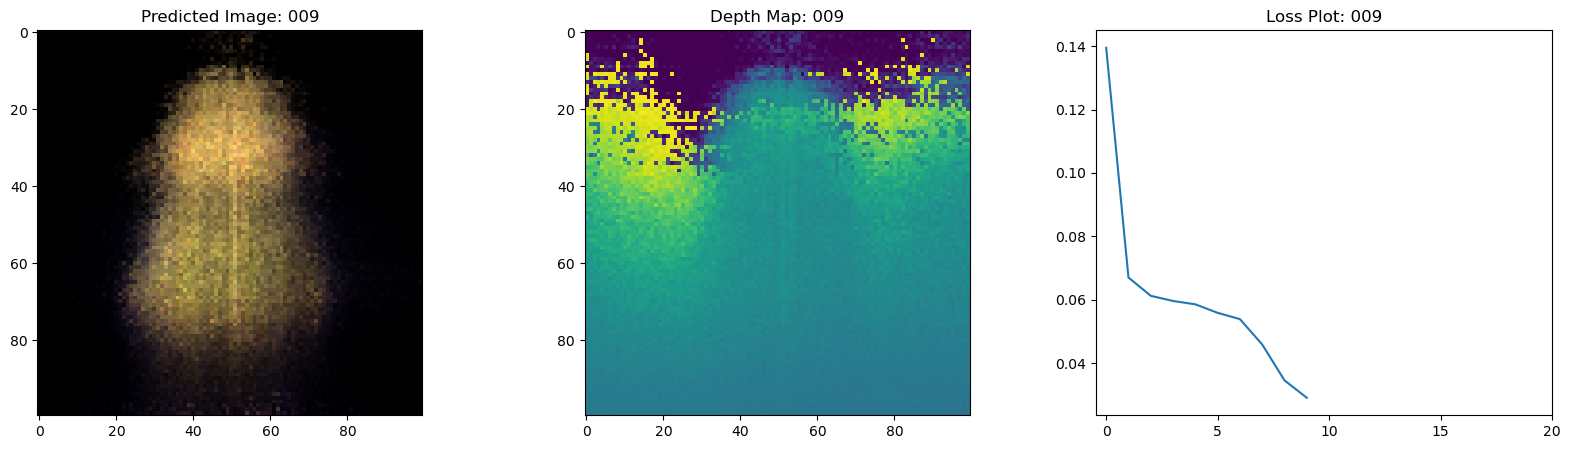

16/16 [==============================] - 41s 2s/step - loss: 0.0290 - psnr: 15.6582 - val_loss: 0.0281 - val_psnr: 15.7089
Epoch 11/20
1/1 [==============================] - 1s 823ms/steposs: 0.0266 - psnr: 15.96


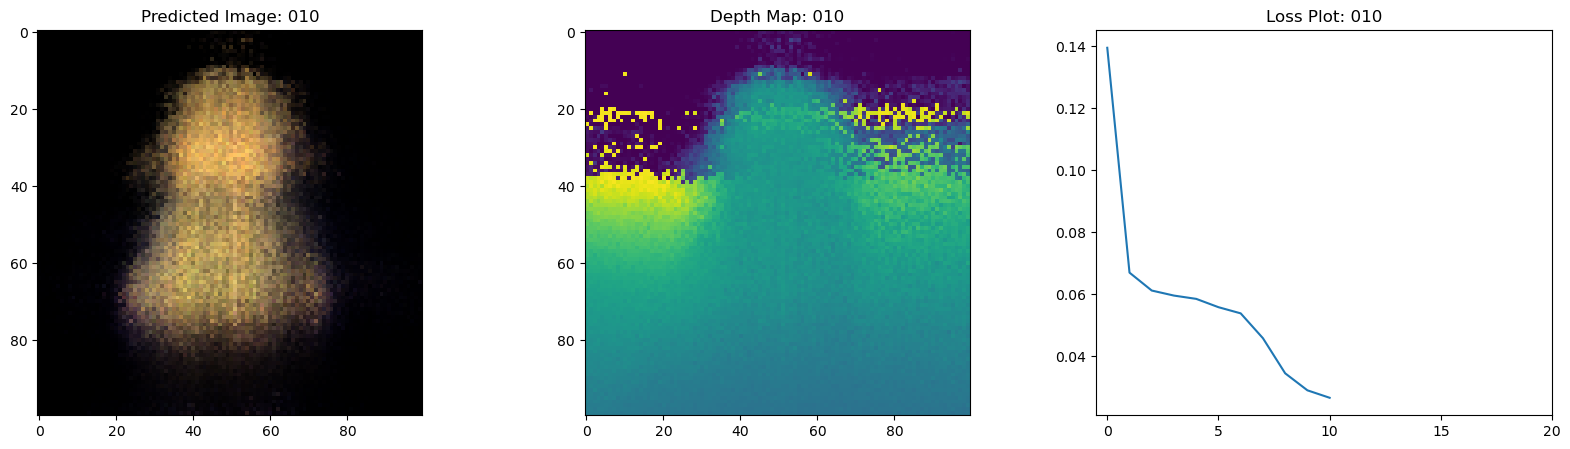

16/16 [==============================] - 38s 2s/step - loss: 0.0266 - psnr: 15.9639 - val_loss: 0.0258 - val_psnr: 16.0507
Epoch 12/20
1/1 [==============================] - 1s 829ms/steposs: 0.0235 - psnr: 16.51


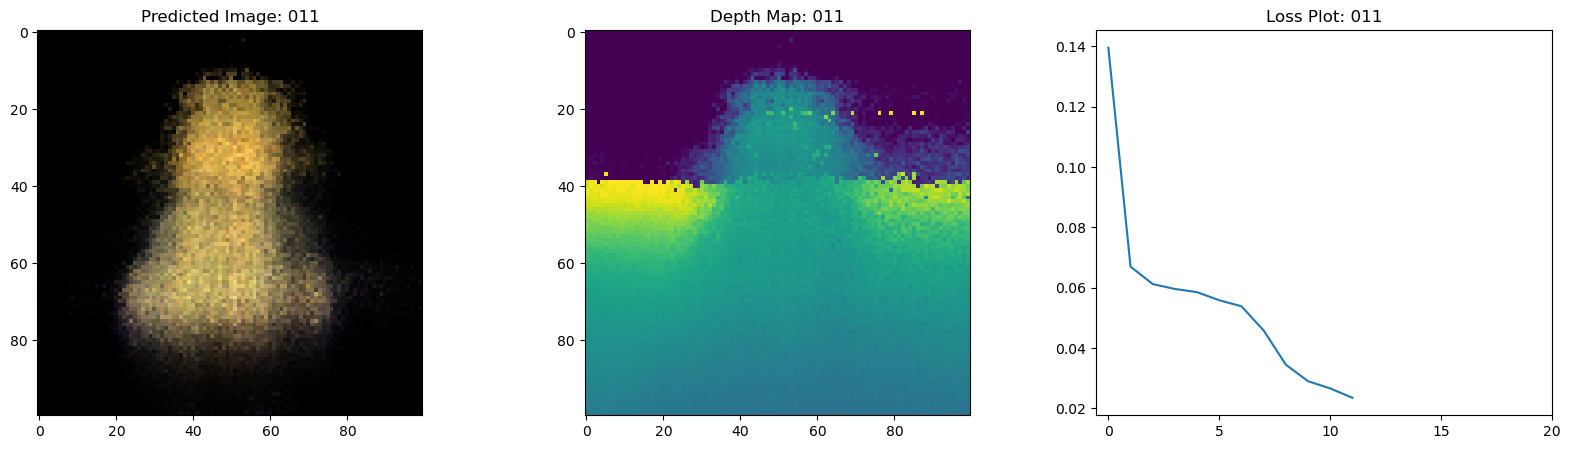

16/16 [==============================] - 41s 2s/step - loss: 0.0235 - psnr: 16.5122 - val_loss: 0.0233 - val_psnr: 16.4854
Epoch 13/20
1/1 [==============================] - 1s 890ms/steposs: 0.0214 - psnr: 16.89


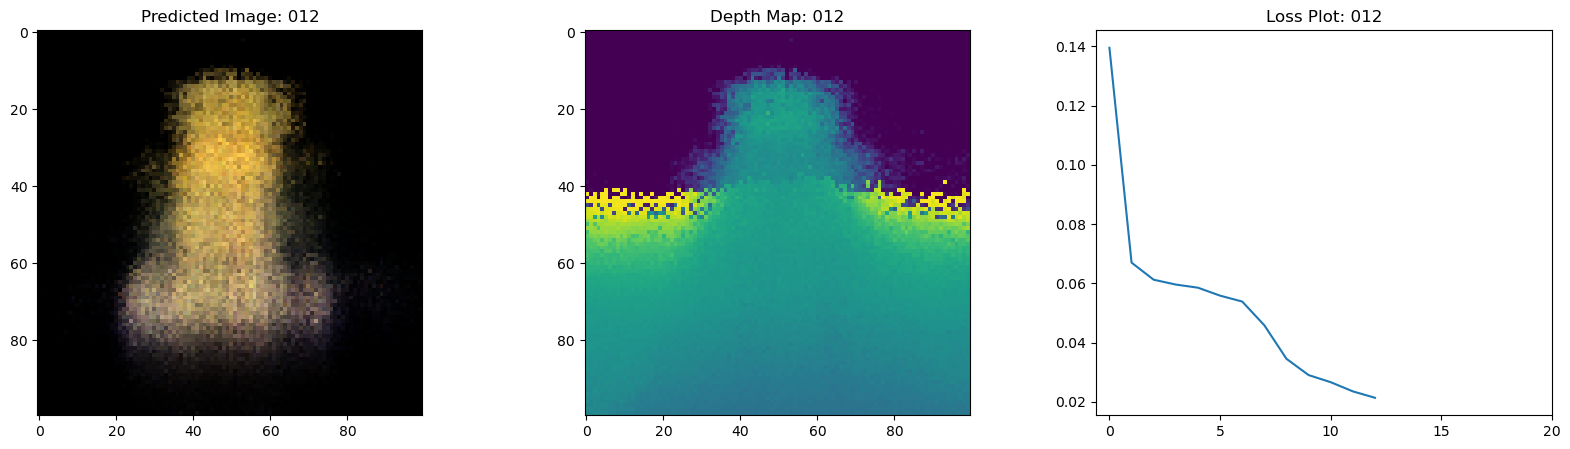

16/16 [==============================] - 39s 2s/step - loss: 0.0214 - psnr: 16.8953 - val_loss: 0.0197 - val_psnr: 17.1396
Epoch 14/20
1/1 [==============================] - 1s 867ms/steposs: 0.0185 - psnr: 17.46


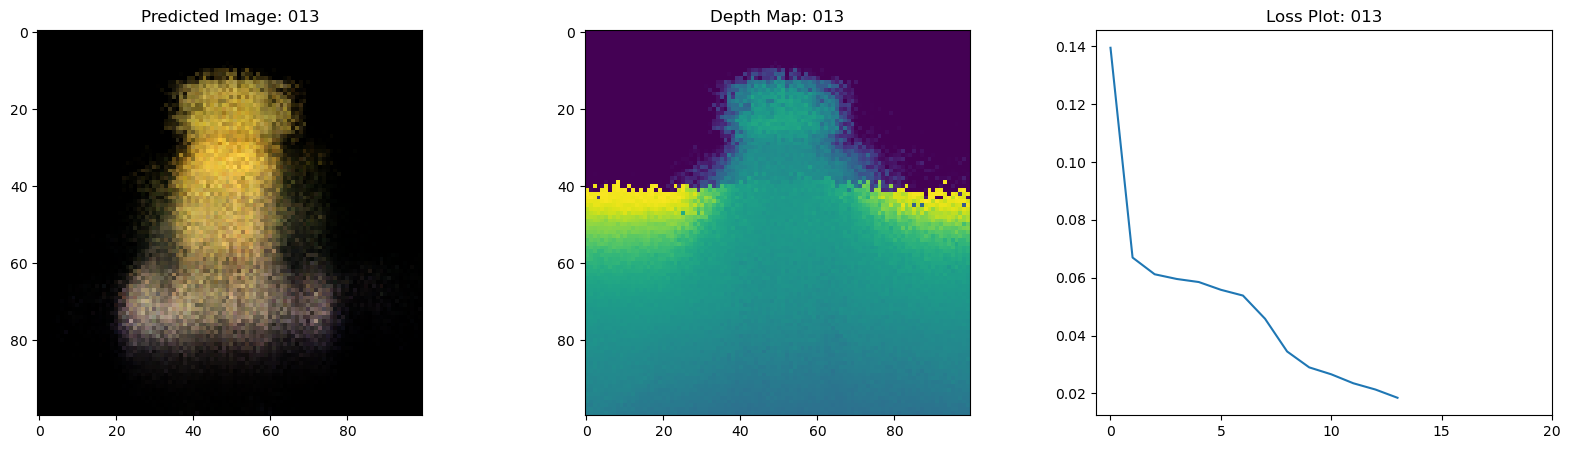

16/16 [==============================] - 41s 2s/step - loss: 0.0185 - psnr: 17.4674 - val_loss: 0.0170 - val_psnr: 17.7396
Epoch 15/20
1/1 [==============================] - 1s 836ms/steposs: 0.0168 - psnr: 17.89


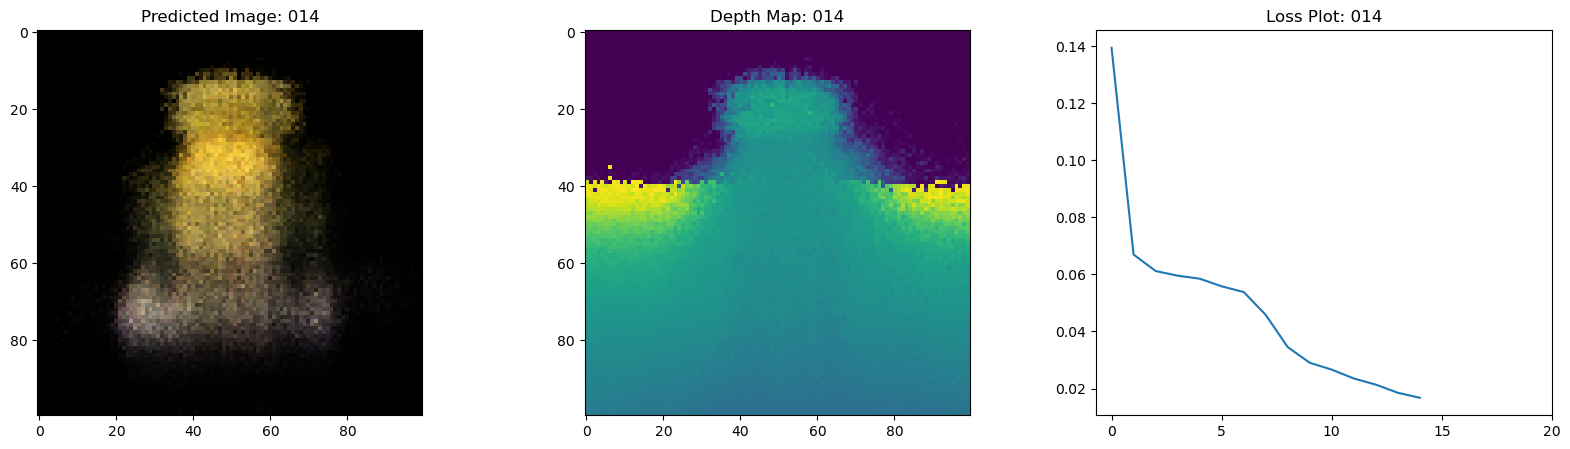

16/16 [==============================] - 40s 2s/step - loss: 0.0168 - psnr: 17.8934 - val_loss: 0.0171 - val_psnr: 17.7269
Epoch 16/20
1/1 [==============================] - 1s 829ms/steposs: 0.0167 - psnr: 17.91


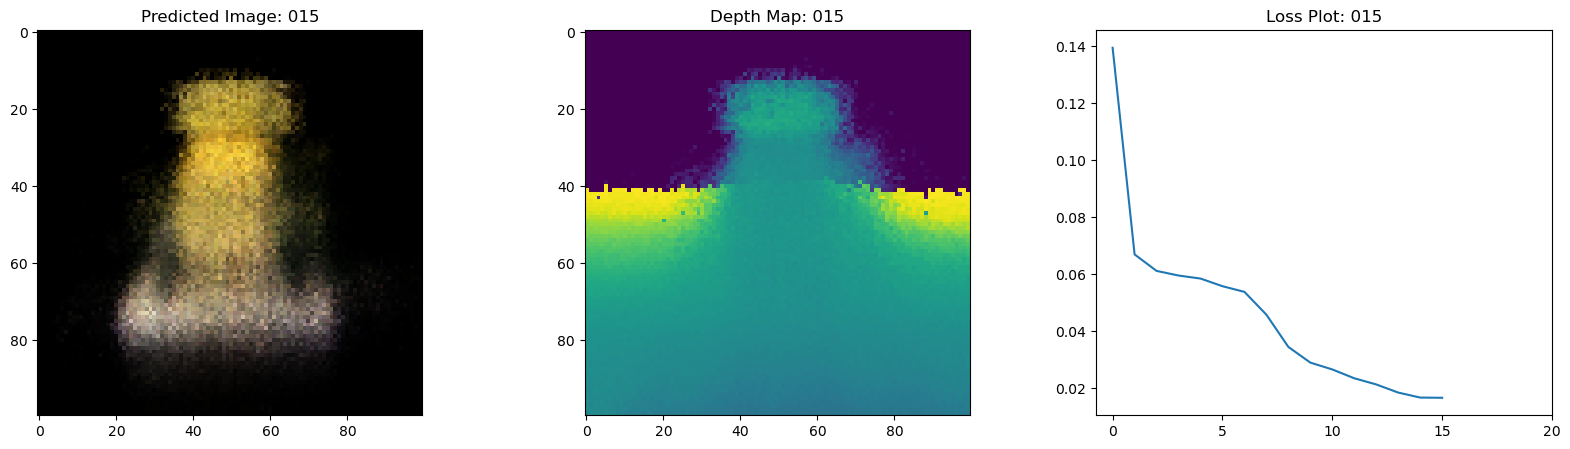

16/16 [==============================] - 41s 3s/step - loss: 0.0167 - psnr: 17.9133 - val_loss: 0.0156 - val_psnr: 18.1246
Epoch 17/20
1/1 [==============================] - 1s 815ms/steposs: 0.0151 - psnr: 18.34


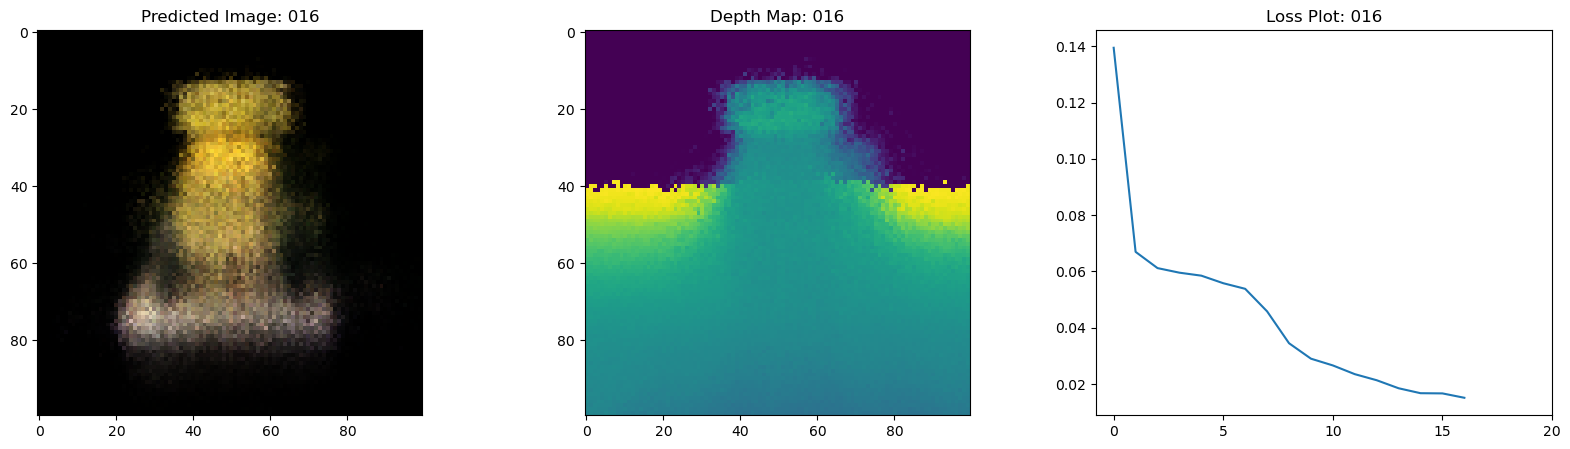

16/16 [==============================] - 38s 2s/step - loss: 0.0151 - psnr: 18.3492 - val_loss: 0.0144 - val_psnr: 18.4991
Epoch 18/20
1/1 [==============================] - 1s 824ms/steposs: 0.0139 - psnr: 18.70


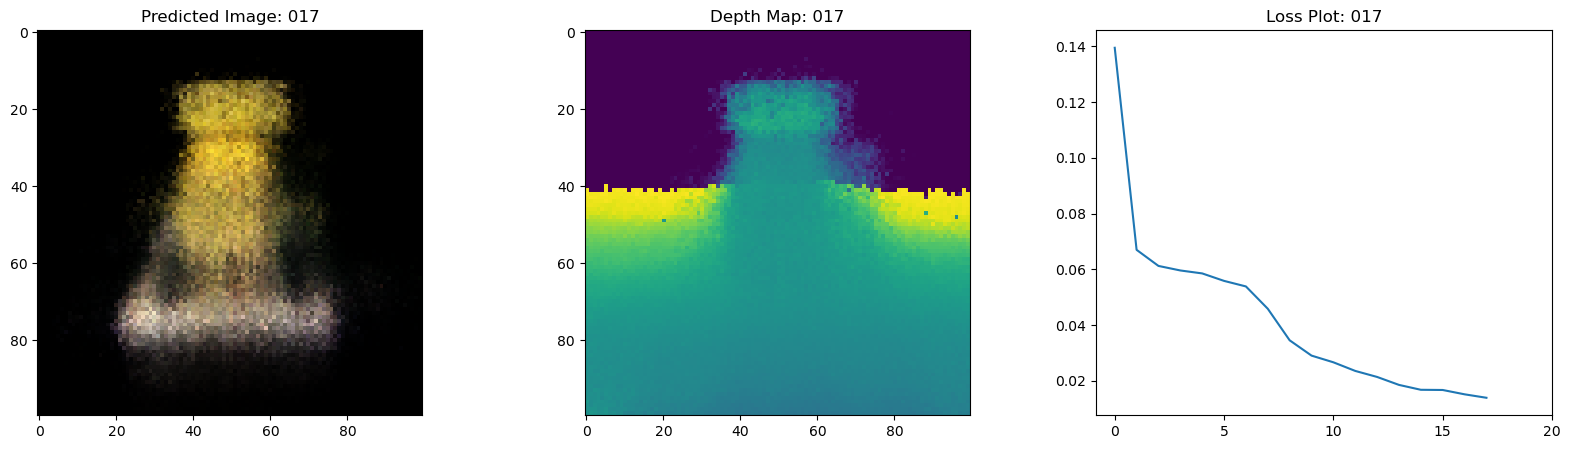

16/16 [==============================] - 41s 3s/step - loss: 0.0139 - psnr: 18.7068 - val_loss: 0.0143 - val_psnr: 18.4980
Epoch 19/20
1/1 [==============================] - 1s 813ms/steposs: 0.0133 - psnr: 18.90


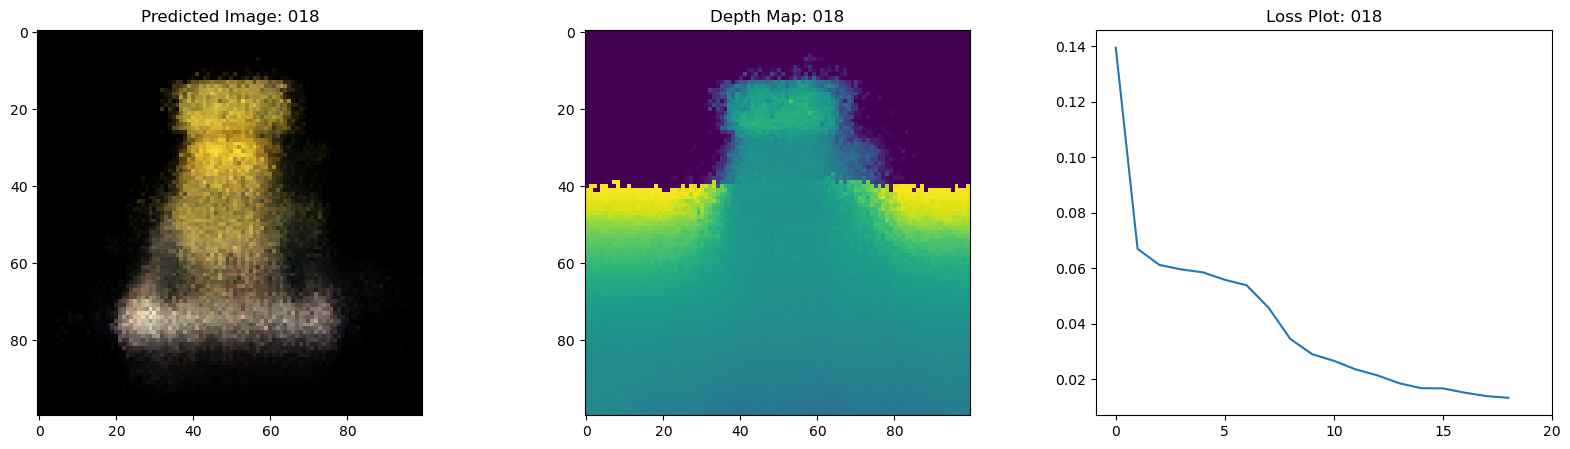

16/16 [==============================] - 38s 2s/step - loss: 0.0133 - psnr: 18.9072 - val_loss: 0.0133 - val_psnr: 18.8194
Epoch 20/20
1/1 [==============================] - 1s 806ms/steposs: 0.0132 - psnr: 18.93


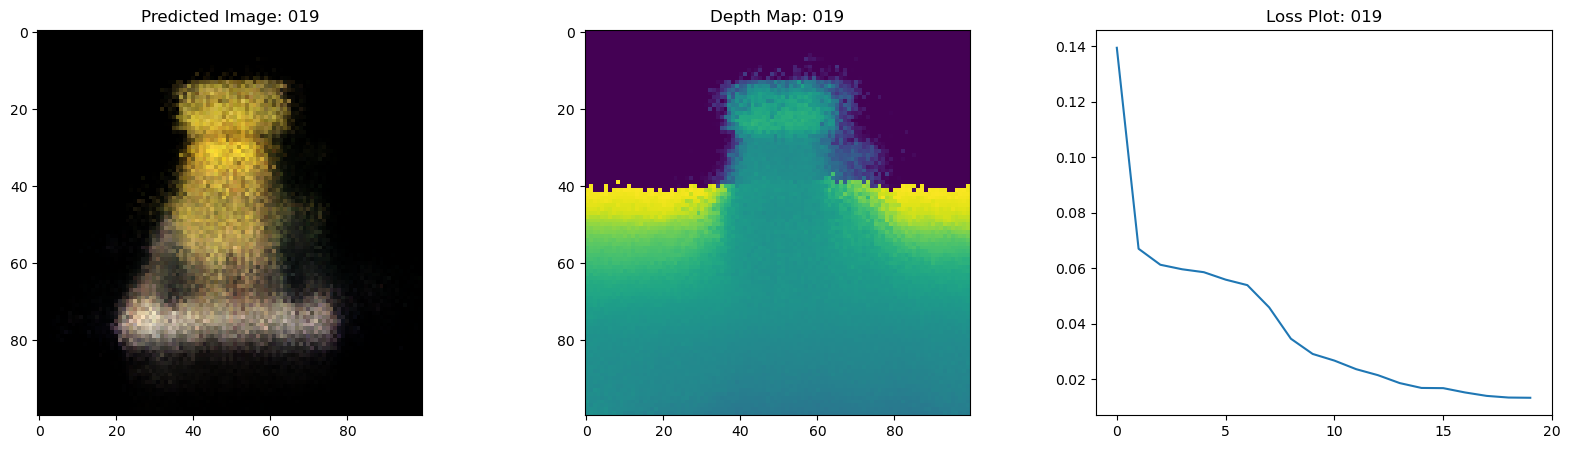

16/16 [==============================] - 38s 2s/step - loss: 0.0132 - psnr: 18.9327 - val_loss: 0.0129 - val_psnr: 18.9799


100%|██████████| 20/20 [00:00<00:00, 40.64it/s]


In [14]:
num_pos = H * W * NUM_SAMPLES
nerf_model = get_nerf_model(num_layers=8, num_pos=num_pos)

model = NeRF(nerf_model)
model.compile(
    optimizer=keras.optimizers.Adam(0.01), loss_fn=keras.losses.MeanSquaredError()
)

# Create a directory to save the images during training.
if not os.path.exists("images"):
    os.makedirs("images")
model.fit(
    train_ds,
    validation_data=val_ds,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    callbacks=[TrainMonitor()],
    steps_per_epoch=split_index // BATCH_SIZE,
)


def create_gif(path_to_images, name_gif):
    filenames = glob.glob(path_to_images)
    filenames = sorted(filenames)
    images = []
    for filename in tqdm(filenames):
        images.append(imageio.imread(filename))
    kargs = {"duration": 0.25}
    imageio.mimsave(name_gif, images, "GIF", **kargs)


create_gif("images/*.png", "training.gif")